# Active Learning Using Support Vector Machines

### Sitao Min

### (a) Download the banknote authentication Data Set from: https://archive.ics.uci.edu/ml/datasets/banknote+authentication. Choose 472 data points randomly as the test set. This is a binary classification problem.

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from numpy import linalg as LA
from sklearn.utils import resample
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import time as time
import warnings
warnings.filterwarnings("ignore")

data1_path = 'data_banknote_authentication.txt'
data1 = pd.read_table(data1_path,sep = ',',header = None)
data1.columns = ['variance','skewness','cutorsis','entropy','class']

In [72]:
data1.head()

,variance,skewness,cutorsis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [73]:
data1.shape

(1372, 5)

In [248]:
from sklearn.utils import resample

test_data = resample(data1, n_samples = 472 ,replace = False, random_state = 1)

print(test_data.shape)

train_data = data1.drop(test_data.index.values,axis = 0)

print(train_data.shape)
train_data['class'].value_counts()

(472, 5)
(900, 5)


0    489
1    411
Name: class, dtype: int64

### (b) Monte Carlos Simulations of Active and Passive Learning

### i. Passive Learning: Train a SVM with a pool of 10 randomly selected data points from the training set using linear kernel and L1 penalty. Repeat this process by adding 10 other randomly selected data points to the pool, until you use all the 900 points. 

In [249]:
from sklearn.preprocessing import StandardScaler
X_train = train_data.iloc[:,0:-1]
X_test = test_data.iloc[:,0:-1]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

train_data.iloc[:,0:-1] = X_train
test_data.iloc[:,0:-1] = X_test

In [250]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
def handle_svm(train_data,test_data,threshold, verbose = False, low_begin = -8, low_end = 0, 
                                               up_begin = 8, up_end = 0, n_samples = 5):
    
    X_train = train_data.iloc[:,0:-1]
    y_train = train_data.iloc[:,-1]
    X_test = test_data.iloc[:,0:-1]
    y_test = test_data.iloc[:,-1]
    
    upper_threshold = 0
    lower_threshold = 0
    
    # find lower and upper threshold
    for i in range(low_begin,low_end+1):
        estimator = svm.LinearSVC(C = 10**(i),penalty = 'l1',random_state = 21,dual = False)
        estimator.fit(X_train,y_train)
        y_pred = estimator.predict(X_train)
        accuracy = accuracy_score(y_train,y_pred)
        if(accuracy >= threshold):
            lower_threshold = i 
            break
        if i == 0:
            raise NameError('Cannot find Lower threshold,please increase scale!')
            
    for i in range(up_begin,up_end-1):
        estimator = svm.LinearSVC(penalty = 'l1',random_state = 21, C = 10**(i),dual = False)
        estimator.fit(X_train,y_train)
        y_pred = estimator.predict(X_train)
        accuracy = accuracy_score(y_train,y_pred)
        if(accuracy >= threshold):
            upper_threshold = i
            break
        if i == 0:
            print('not found')
            raise NameError('Cannot find Upper threshold,please increase scale!') 
    
    if(verbose == True):
        print(lower_threshold,upper_threshold)
    C_list = np.logspace(lower_threshold,upper_threshold,n_samples)
    
    estimator = svm.LinearSVC(penalty = 'l1',random_state = 21,dual = False)
    
    grid_search = GridSearchCV(estimator, param_grid = {'C':C_list}, cv = StratifiedKFold(5),refit = True)
    grid_search.fit(X_train,y_train)
    
    bst = grid_search.best_estimator_
    
    bst.fit(X_train,y_train)
    y_pred = bst.predict(X_test)
    
    error = 1 - accuracy_score(y_test,y_pred)
    
    if(verbose == True):
        print('best params:',grid_search.best_params_['C'])
        print('svm error:',error)
    
    return error,bst

In [227]:
from sklearn.utils import resample

def train_passive_svms(train_data, test_data,random_state,verbose = False):
    
    pool = resample(train_data, n_samples = 10,random_state = random_state,replace = False)
    error_list = []
    model_list = []
    
    for i in range(1,int(len(train_data)/10)+1):
    
        error,model = handle_svm(pool,test_data,0.9, verbose = verbose)
        error_list.append(error)
        model_list.append(model)
        selected_data = resample(train_data, n_samples = 10,replace = False,random_state = random_state)
        pool = pd.concat([pool,selected_data],axis = 0)
    
    return error_list,model_list

In [252]:
svms_error_passive = pd.DataFrame(np.ones((50,90)))

for i in range(0,50):
    error_list, model_list = train_passive_svms(train_data, test_data, random_state = i+4)
    svms_error_passive.iloc[i,:] = error_list
    print('round %i finished'%i)

round 0 finished
round 1 finished
round 2 finished
round 3 finished
round 4 finished
round 5 finished
round 6 finished
round 7 finished
round 8 finished
round 9 finished
round 10 finished
round 11 finished
round 12 finished
round 13 finished
round 14 finished
round 15 finished
round 16 finished
round 17 finished
round 18 finished
round 19 finished
round 20 finished
round 21 finished
round 22 finished
round 23 finished
round 24 finished
round 25 finished
round 26 finished
round 27 finished
round 28 finished
round 29 finished
round 30 finished
round 31 finished
round 32 finished
round 33 finished
round 34 finished
round 35 finished
round 36 finished
round 37 finished
round 38 finished
round 39 finished
round 40 finished
round 41 finished
round 42 finished
round 43 finished
round 44 finished
round 45 finished
round 46 finished
round 47 finished
round 48 finished
round 49 finished


### ii. Active Learning: Train a SVM with a pool of 10 randomly selected data points from the training set using linear kernel and L1 penalty. Select the parameters of the SVM with 10-fold cross validation. Choose the 10 closest data points in the training set to the hyperplane of the SVM2 and add them to the pool.


In [79]:
from sklearn.utils import resample
from numpy import linalg as LA

def train_active_svms(train_data, test_data, random_state, verbose = False):
    
    pool = resample(train_data, n_samples = 10, random_state = ramdom_state, replace = False)
    
    error_list = []
    model_list = []
    
    train_data_copy = train_data.copy()
    
    for i in range(1,int(len(train_data)/10)+1):
    
        error, model = handle_svm(pool,test_data,0.7, verbose = verbose)
        error_list.append(error)
        model_list.append(model)
        
        w = model.coef_
        b = model.intercept_ 
        features = train_data_copy.iloc[:,0:-1].values
        
        distance = (np.inner(w,features) - b)/LA.norm(w)
        selected_index = np.argsort(distance).ravel()
        selected_index = selected_index[0:10]
        selected_data = train_data_copy.iloc[selected_index,:]
        train_data_copy = train_data_copy.drop(index = selected_data.index)
        
        pool = pd.concat([pool,selected_data],axis = 0)
    
    return error_list,model_list

In [80]:
import warnings
warnings.filterwarnings("ignore")

svms_error_active = pd.DataFrame(np.ones((50,90)))

for i in range(0,50):
    error_list, model_list = train_active_svms(train_data, test_data,random_state = i)
    svms_error_active.iloc[i,:] = error_list
    print('round %i finished'%i)

round 0 finished
round 1 finished
round 2 finished
round 3 finished
round 4 finished
round 5 finished
round 6 finished
round 7 finished
round 8 finished
round 9 finished
round 10 finished
round 11 finished
round 12 finished
round 13 finished
round 14 finished
round 15 finished
round 16 finished
round 17 finished
round 18 finished
round 19 finished
round 20 finished
round 21 finished
round 22 finished
round 23 finished
round 24 finished
round 25 finished
round 26 finished
round 27 finished
round 28 finished
round 29 finished
round 30 finished
round 31 finished
round 32 finished
round 33 finished
round 34 finished
round 35 finished
round 36 finished
round 37 finished
round 38 finished
round 39 finished
round 40 finished
round 41 finished
round 42 finished
round 43 finished
round 44 finished
round 45 finished
round 46 finished
round 47 finished
round 48 finished
round 49 finished


### (c) Result

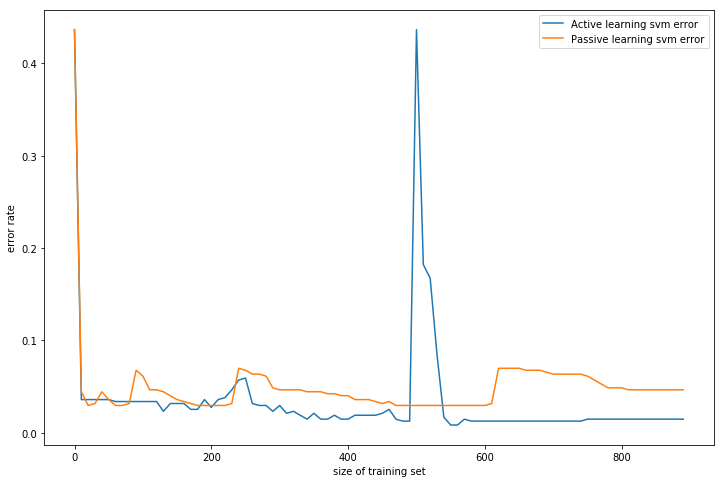

In [81]:
x = range(0,900,10)
plt.figure(figsize=(12,8))
plt.plot(x,svms_error_active.mean().values,label = 'Active learning svm error')
plt.plot(x,svms_error_passive.mean().values,label = 'Passive learning svm error')
plt.legend()
plt.xlabel('size of training set')
plt.ylabel('error rate')
plt.show()

In [155]:
svms_error_active.to_csv('Q1_b-i.csv')
svms_error_passive.to_csv('Q1_b-ii.csv')